In [ ]:
!pip install matplotlib scipy numpy pandas pillow shapely

In [ ]:
# USER PARAMETERS

# N.B. to edit the device geometry, change the "regions_generator.py" script before running. 

params = {
    'nx': 250, 'ny': 50, 'nz': 20,
    'dx': 20e-9, 'dy': 20e-9, 'dz': 10e-9,
    'geom_png': 'mumax_geometry.png',
    'regions_ovf': 'regions_map.ovf',
    'Msat_device': 1.4e5,
    'Aex_device': 3.5e-12,
    'edge_alpha': 0.5,
    'device_alpha': 2e-4,
    # Dot material parameters
    'Msat_dot': 1.145e6/2,
    'Aex_dot': 7.5e-12,
    'alpha_dot': 0.2,
    'n_dots': 5,
    'dot_diameter': 100e-9,
    # Alpha profile
    'alpha_k': -5.0,  # shape parameter for alpha edge profile
    # Stripline geometry
    'stripline_x': -2.5e-6 + 350e-9,
    'stripline_width': 300e-9,
    'stripline_height': 0.8e-6,
    # Excitation frequencies and field amplitudes
    'f1': 2.6e9, 'f2': 2.8e9,
    'Bz_ext': 0.2,       # static B-field along z (Tesla)
    'By_amp': 0.1e-3,    # y-oscillation amplitude (Tesla) used for both tones
    # Simulation timing
    'T': 50e-9, 'sample_dt': 50e-12,
    # Detection region alignment (to account for margins)
    'detector_offset_x_cells': 1,          # shift both detectors in +x by N cells
    'detector_top_offset_y_cells': -5,     # shift top detector by N cells (positive = +y)
    'detector_bottom_offset_y_cells': 5,   # shift bottom detector by N cells (positive = +y)
    'detector_size': 270e-9,               # square detector side length (meters)
    # Optimizer selection & ranges
    'optimizer': 'DE',                     # 'GA' or 'DE'
    'x_range': (-2e-6, -0.1e-6),
    'y_range': (-0.4e-6, 0.4e-6),
    # Optimizer settings
    'population_size': 1,                  # used by GA and DE (DE will bump to >=4 internally)
    'n_generations': 1,                    # GA: generations; DE: iterations
    # GA-only settings
    'crossover_rate': 0.7,                 # GA crossover 
    'mutation_rate': 0.2,
    'mutation_std': 100e-9,
    'elite_fraction': 0.2,
    # DE-only settings
    'de_F': 0.8,                           # DE mutation factor
    'de_CR': 0.7,                          # DE crossover probability
    # Fitness weights
    'output_magnitude_weight': 0.5, # weighting factor for output magnitude in fitness calculation
    'selectivity_weight': 0.5       # weighting factor for selectivity in fitness calculation
}
print('Parameters loaded. Edit this cell to adjust simulation and optimizer settings.')

Parameters loaded. Edit this cell to adjust simulation and optimizer settings.


In [ ]:
# IMPORT MODULES AND SETUP OPTIMIZER

import time
import numpy as np
import matplotlib.pyplot as plt
from genetic_optimizer import GeneticOptimizer, ParallelEvaluator
from simulation_worker import evaluate_individual

# Optimization parameters
n_generations = params['n_generations']
population_size = params['population_size']
n_dots = params['n_dots']
optimizer_type = params.get('optimizer', 'GA')

# Initialize optimizer(s)
if optimizer_type == 'GA':
    optimizer = GeneticOptimizer(
        population_size=population_size,
        n_dots=n_dots,
        x_range=params['x_range'],
        y_range=params['y_range'],
        mutation_rate=params['mutation_rate'],
        mutation_std=params['mutation_std'],
        crossover_rate=params['crossover_rate'],
        elite_fraction=params['elite_fraction']
    )

    # Initialize population with time-based seed for variability
    seed = int(time.time()) & 0xFFFFFFFF
    optimizer.initialize_population(seed=seed)
    print(f"Initialized GA population with seed: {seed}")

    # Create parallel evaluator (automatically detects GPUs)
    evaluator = ParallelEvaluator()

    print("\nStarting GA optimization...")
    print(f"Population size: {population_size}")
    print(f"Number of dots: {n_dots}")
    print(f"Generations: {n_generations}")
else:
    print("\nUsing Differential Evolution optimizer")
    print(f"Number of dots: {n_dots}")

Initialized population of 1 individuals
Each individual has 5 dots
Initialized population with seed: 1765210886
Parallel evaluator initialized with 1 workers

Starting parallel optimization...
Population size: 1
Number of dots: 5
Generations: 1


In [5]:
# GENERATE GEOMETRY AND REGIONS FILES

# Prepare geometry PNG and regions OVF before optimization
# This creates 253 regions for exponential edge alphas (1 region saved for stripline, 1 saved for other elements e.g. magnetic dots)
import os
import numpy as np
from PIL import Image

# Pull grid and cell sizes from params
dx = params['dx']; dy = params['dy']; dz = params['dz']
nx = params['nx']; ny = params['ny']; nz = params['nz']
regions_png = params['regions_ovf'].replace('regions_map.ovf','mumax_regions.png') if 'regions_ovf' in params else 'mumax_regions.png'
geom_png = params['geom_png']
ovf_path = params['regions_ovf']

# 1) Generate geometry/regions PNG via regions_generator (geometry png is required)
try:
    import regions_generator
    print("Generating geometry/regions PNGs via regions_generator...")
    regions_path, geom_path = regions_generator.generate_regions_image(
        output_path=regions_png,
        geom_path=geom_png
    )
    print(f"Generated: {regions_path}, {geom_path}")
except Exception as e:
    print(f"Warning: PNG generation skipped or failed: {e}")

if not (os.path.exists(regions_png) and os.path.exists(geom_png)):
    raise FileNotFoundError("Missing 'mumax_regions.png' or 'mumax_geometry.png'.")

# Ensure geometry PNG is the right size
geom_img = Image.open(geom_png).convert('L')
if geom_img.size != (nx, ny):
    print(f"Resizing geometry PNG from {geom_img.size} to ({nx}, {ny})")
    geom_img = geom_img.resize((nx, ny), resample=Image.NEAREST)
geom_img.save(geom_png)

# 2) Build 3D regions OVF file (uniform along z) from 2D PNG
arr2d = np.array(Image.open(regions_png).convert('L'))
if arr2d.shape != (ny, nx):
    print(f"Note: resizing regions PNG from {arr2d.shape} to (ny, nx)=({ny}, {nx}) for OVF consistency")
    arr2d = np.array(Image.fromarray(arr2d).resize((nx, ny), resample=Image.NEAREST))
regions3d = np.repeat(arr2d[None, :, :], nz, axis=0).astype(np.int32)

def write_ovf_text_scalar(path, data3d, dx, dy, dz):
    nz, ny, nx = data3d.shape
    xmax = nx * dx; ymax = ny * dy; zmax = nz * dz
    with open(path, 'w') as f:
        f.write('# OOMMF OVF 2.0\n')
        f.write('# Segment count: 1\n')
        f.write('# Begin: Segment\n')
        f.write('# Begin: Header\n')
        f.write('# Title: regions\n')
        f.write('# meshtype: rectangular\n')
        f.write('# meshunit: m\n')
        f.write('# xmin: 0\n')
        f.write('# ymin: 0\n')
        f.write('# zmin: 0\n')
        f.write(f'# xmax: {xmax}\n')
        f.write(f'# ymax: {ymax}\n')
        f.write(f'# zmax: {zmax}\n')
        f.write('# valuedim: 1\n')
        f.write('# valuelabels: regions\n')
        f.write('# valueunits: 1\n')
        f.write(f'# xbase: {dx/2}\n')
        f.write(f'# ybase: {dy/2}\n')
        f.write(f'# zbase: {dz/2}\n')
        f.write(f'# xnodes: {nx}\n')
        f.write(f'# ynodes: {ny}\n')
        f.write(f'# znodes: {nz}\n')
        f.write(f'# xstepsize: {dx}\n')
        f.write(f'# ystepsize: {dy}\n')
        f.write(f'# zstepsize: {dz}\n')
        f.write('# End: Header\n')
        f.write('# Begin: Data Text\n')
        # Fortran-like flatten: x fastest, then y, then z
        for k in range(nz):
            for j in range(ny):
                for i in range(nx):
                    f.write(f'{int(data3d[k, j, i])} \n')
        f.write('# End: Data Text\n')
        f.write('# End: Segment\n')

write_ovf_text_scalar(ovf_path, regions3d, dx, dy, dz)
print(f"Wrote OVF to {ovf_path} with shape (nz, ny, nx)=({nz}, {ny}, {nx})")

Generating geometry/regions PNGs via regions_generator...
Generated: mumax_regions.png, mumax_geometry.png
Resizing geometry PNG from (270, 70) to (250, 50)
Note: resizing regions PNG from (70, 270) to (ny, nx)=(50, 250) for OVF consistency
Wrote OVF to regions_map.ovf with shape (nz, ny, nx)=(20, 50, 250)


In [ ]:
# RUN THE OPTIMIZATION LOOP

# Enable debug messages for regions_map handling
params['debug_regions_map'] = True

if optimizer_type == 'GA':
    for gen in range(n_generations):
        print(f"\n{'='*60}")
        print(f"GENERATION {gen}")
        print(f"{'='*60}")
        
        # Get current population
        population = optimizer.get_current_population()
        
        # Evaluate population in parallel across GPUs (pass full params)
        results = evaluator.evaluate_population(population, gen, params)
        
        # Extract fitness scores for GA
        fitness_scores = [res.get('fitness', 0.0) for res in results]
        
        # Update optimizer with fitness scores
        optimizer.set_fitness_scores(fitness_scores)
        
        # Save checkpoint
        optimizer.save_checkpoint(f'checkpoint_gen{gen}.json')
        
        # Evolve to next generation (unless this is the last generation)
        if gen < n_generations - 1:
            optimizer.evolve()

    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE (GA)")
    print("="*60)
else:
    # Differential Evolution implemented with existing ParallelEvaluator to avoid I/O races
    import numpy as np
    import time
    import math

    # Helper: pack/unpack between vectors and dot tuples
    def vec_to_dots(vec):
        return [(vec[2*i], vec[2*i+1]) for i in range(n_dots)]
    def dots_to_vec(dots):
        v = []
        for (x, y) in dots:
            v.extend([x, y])
        return np.array(v, dtype=float)

    # Bounds per coordinate
    x_min, x_max = params['x_range']
    y_min, y_max = params['y_range']
    dim = 2 * n_dots

    # DE hyperparameters (with sensible defaults)
    de_pop = int(params.get('population_size', 8))
    de_gen = int(params.get('n_generations', 10))
    F = float(params.get('de_F', 0.8))
    CR = float(params.get('de_CR', params.get('crossover_rate', 0.7)))

    # DE requires at least 4 individuals for best1bin; bump if needed
    if de_pop < 4:
        print(f"Note: population_size={de_pop} too small for DE; using 4 internally.")
        de_pop = 4

    # Initialize parallel evaluator
    evaluator = ParallelEvaluator()

    # Randomly initialize population within bounds
    def random_vec():
        vec = np.empty(dim, dtype=float)
        for i in range(n_dots):
            vec[2*i]   = np.random.uniform(x_min, x_max)
            vec[2*i+1] = np.random.uniform(y_min, y_max)
        return vec

    pop = np.stack([random_vec() for _ in range(de_pop)], axis=0)

    def clip_bounds(vec):
        for i in range(n_dots):
            vec[2*i]   = min(max(vec[2*i],   x_min), x_max)
            vec[2*i+1] = min(max(vec[2*i+1], y_min), y_max)
        return vec

    def evaluate_vectors(vectors, gen_idx):
        # Convert vectors to dot lists
        population = [vec_to_dots(v) for v in vectors]
        # Use GA-style evaluator to create unique sim names and isolate I/O per task
        results = evaluator.evaluate_population(population, gen_idx, params)
        fitness = np.array([r.get('fitness', 0.0) for r in results], dtype=float)
        return results, fitness

    # Evaluate initial population
    results, fitness = evaluate_vectors(pop, 0)
    best_idx = int(np.argmax(fitness))
    best_vec = pop[best_idx].copy()
    best_fit = float(fitness[best_idx])

    # History for downstream plotting
    hist_gen = [0]
    hist_best = [best_fit]
    hist_mean = [float(np.mean(fitness))]

    print("\nStarting Differential Evolution with ParallelEvaluator...")
    print(f"Population: {de_pop}, Generations: {de_gen}, F={F}, CR={CR}")

    rng = np.random.default_rng()
    for gen_idx in range(1, de_gen + 1):
        trial_pop = np.empty_like(pop)
        # best1bin mutation/crossover
        for i in range(de_pop):
            # choose distinct r1,r2 != i
            choices = [j for j in range(de_pop) if j != i]
            r1, r2 = rng.choice(choices, size=2, replace=False)
            mutant = best_vec + F * (pop[r1] - pop[r2])
            # binomial crossover
            cross_mask = rng.random(dim) < CR
            # ensure at least one dimension from mutant
            if not np.any(cross_mask):
                cross_mask[rng.integers(0, dim)] = True
            trial = np.where(cross_mask, mutant, pop[i])
            trial = clip_bounds(trial)
            trial_pop[i] = trial

        # Evaluate trials
        trial_results, trial_fitness = evaluate_vectors(trial_pop, gen_idx)

        # Selection
        improved = trial_fitness >= fitness
        pop[improved] = trial_pop[improved]
        # keep corresponding results/fitness
        for idx, imp in enumerate(improved):
            if imp:
                results[idx] = trial_results[idx]
        fitness = np.where(improved, trial_fitness, fitness)

        # Update best
        gen_best_idx = int(np.argmax(fitness))
        gen_best_fit = float(fitness[gen_best_idx])
        if gen_best_fit > best_fit:
            best_fit = gen_best_fit
            best_vec = pop[gen_best_idx].copy()

        hist_gen.append(gen_idx)
        hist_best.append(best_fit)
        hist_mean.append(float(np.mean(fitness)))
        print(f"Gen {gen_idx}: best={best_fit:.6f}, mean={hist_mean[-1]:.6f}")

    best_dots = vec_to_dots(best_vec)

    # Provide an optimizer-like shim for downstream cells
    class SimpleOpt:
        def __init__(self, dots, fitness, history):
            self._best = (dots, fitness)
            self.history = history
        def get_best_individual(self):
            return self._best

    optimizer = SimpleOpt(
        best_dots,
        best_fit,
        history={'generations': hist_gen, 'best_fitness': hist_best, 'mean_fitness': hist_mean}
    )

    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE (DE)")
    print("="*60)
    print(f"Best fitness: {best_fit:.6f}")
    print(f"Best dots: {[ (x*1e6, y*1e6) for x,y in best_dots ]}")


GENERATION 0
  Individual 1/1 complete: Fitness = 0.2831 (GPU 0)
[gen 0 indiv 0] [opt_gen0_ind0] debug_regions_map=True
[gen 0 indiv 0] [opt_gen0_ind0] fields keys sample: alpha_map, geom, m000000, m000001, m000002, m000003...
[gen 0 indiv 0] [opt_gen0_ind0] regions_map present; stripline voxels: 105240/250000.

Generation 0 complete:
  Best fitness:  0.2831
  Mean fitness:  0.2831
  Worst fitness: 0.2831
Checkpoint saved to checkpoint_gen0.json

OPTIMIZATION COMPLETE


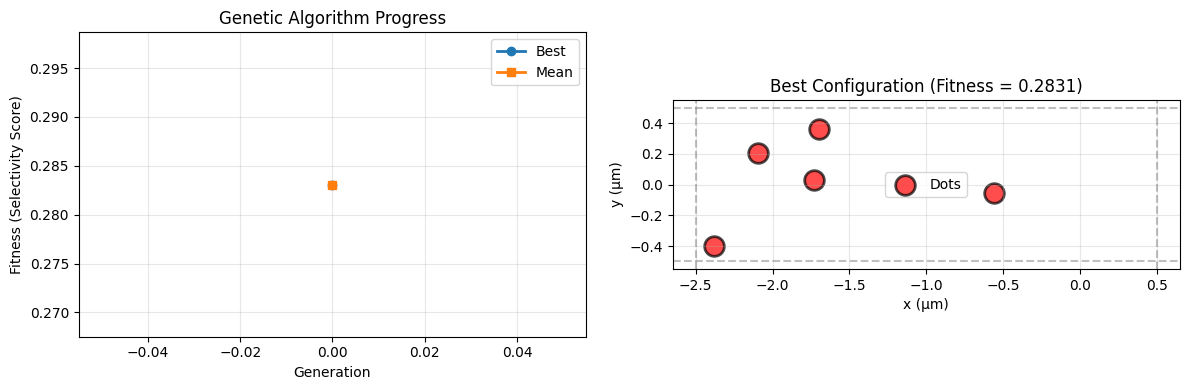


Final best fitness: 0.283087

Best dot positions (µm):
  Dot 1: (-1.6956, 0.3617)
  Dot 2: (-2.3796, -0.3993)
  Dot 3: (-1.7288, 0.0292)
  Dot 4: (-2.0946, 0.2047)
  Dot 5: (-0.5607, -0.0519)


In [7]:
# PLOT OPTIMISATION FITNESS AND BEST CONFIGURATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot fitness evolution
generations = optimizer.history['generations']
best_fitness = optimizer.history['best_fitness']
mean_fitness = optimizer.history['mean_fitness']

ax1.plot(generations, best_fitness, 'o-', label='Best', linewidth=2)
ax1.plot(generations, mean_fitness, 's-', label='Mean', linewidth=2)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness (Selectivity Score)')
ax1.set_title('Genetic Algorithm Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot best dot configuration
best_individual, best_fitness_final = optimizer.get_best_individual()
x_coords = [pos[0] * 1e6 for pos in best_individual]  # Convert to µm
y_coords = [pos[1] * 1e6 for pos in best_individual]

ax2.scatter(x_coords, y_coords, s=200, c='red', marker='o', 
           edgecolors='black', linewidths=2, alpha=0.7, label='Dots')
ax2.set_xlabel('x (µm)')
ax2.set_ylabel('y (µm)')
ax2.set_title(f'Best Configuration (Fitness = {best_fitness_final:.4f})')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add device boundaries as reference
ax2.axvline(-2.5, color='gray', linestyle='--', alpha=0.5, label='Device edge')
ax2.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(-0.5, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('optimization_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal best fitness: {best_fitness_final:.6f}")
print(f"\nBest dot positions (µm):")
for i, (x, y) in enumerate(best_individual):
    print(f"  Dot {i+1}: ({x*1e6:.4f}, {y*1e6:.4f})")

In [8]:
# RE-RUN THE SIMULATION WITH THE BEST CONFIGURATION AND GENERATE FFT RESULTS

from simulation_worker import run_mumax3, build_magnetization_array, mag_tfft_select, measure_region_amplitude
from mumax_script import build_mumax_script
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.io import savemat

# Check if optimizer exists, if not load from checkpoint
if 'optimizer' not in globals():
    print("Optimizer not found in memory. Loading from checkpoint...")
    from genetic_optimizer import GeneticOptimizer
    import glob
    import re
    
    # Find all checkpoint files
    checkpoint_files = glob.glob('checkpoint_gen*.json')
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found. Please run the optimization first (cells 1-2).")
    
    # Extract generation numbers and sort numerically
    def get_generation_number(filename):
        match = re.search(r'checkpoint_gen(\d+)\.json', filename)
        return int(match.group(1)) if match else -1
    
    checkpoint_files.sort(key=get_generation_number)
    latest_checkpoint = checkpoint_files[-1]
    print(f"Loading: {latest_checkpoint}")
    
    optimizer = GeneticOptimizer(
        population_size=params['population_size'],
        n_dots=params['n_dots'],
        x_range=(-2.4e-6, -0.1e-6),
        y_range=(-0.4e-6, 0.4e-6),
        mutation_rate=params['mutation_rate'],
        mutation_std=params['mutation_std'],
        crossover_rate=params['crossover_rate'],
        elite_fraction=params['elite_fraction']
    )
    optimizer.load_checkpoint(latest_checkpoint)
    print("Checkpoint loaded successfully!")

print("\nRe-running simulation with optimized dot positions...")

# Get best individual
best_dots, best_fitness = optimizer.get_best_individual()
print(f"\nBest fitness: {best_fitness:.6f}")
print(f"Dot positions:")
for i, (x, y) in enumerate(best_dots):
    print(f"  Dot {i+1}: ({x*1e6:.4f}, {y*1e6:.4f}) µm")

# Generate MuMax3 script from shared generator and params
script = build_mumax_script(params, best_dots)

# Run simulation
table, fields = run_mumax3(script, name='best_configuration', verbose=True)
savemat("output.mat",fields,appendmat=True)
print("\nSimulation complete! Building magnetization array and performing FFT...")

# Build 5D magnetization array
M, timestamps = build_magnetization_array(fields, pattern='m')
print(f"Magnetization array shape: {M.shape}")

# Extract geometry for dot overlay
geom = fields['geom']
# Geometry is 4D: (component, z, y, x) - take first component (region labels)
if geom.ndim == 4:
    geom = geom[0, :, :, :]  # Extract region labels
nz, ny, nx = geom.shape

# Get physical coordinates
device_size_x = params['dx'] * params['nx']
device_size_y = params['dy'] * params['ny']
x_phys = np.linspace(-device_size_x/2, device_size_x/2, nx)
y_phys = np.linspace(-device_size_y/2, device_size_y/2, ny)

# Extract dots from upper half of geometry
dots_geom = geom[nz//2:, :, :]
dots_map = (dots_geom == 254).any(axis=0)

# Perform FFT analysis on y component (excited by stripline)
dt = params['sample_dt']
freq_targets = [params['f1'], params['f2']]
maps, fpos = mag_tfft_select(M, component='y', dt=dt, fsel=freq_targets, 
                             dimorder='zyx', detrend=True, window='hann', stat='amp')

print(f"FFT complete. Extracted frequencies: {fpos/1e9} GHz")

# Measure output amplitudes
measurement_size = params.get('detector_size', 300e-9)
right_edge_x = device_size_x/2
x_shift = params.get('detector_offset_x_cells', 0) * params['dx']
y_shift_top = params.get('detector_top_offset_y_cells', 0) * params['dy']
y_shift_bottom = params.get('detector_bottom_offset_y_cells', 0) * params['dy']

# Place detectors near right side, adjusted by individual top/bottom offsets
output_top_center = (right_edge_x - 1.0e-6 + x_shift, 0.35e-6 + y_shift_top)
output_bottom_center = (right_edge_x - 1.0e-6 + x_shift, -0.35e-6 + y_shift_bottom)

results = {}
for i, (fmap, f) in enumerate(zip(maps, fpos)):
    freq_label = f"{f/1e9:.2f} GHz"
    
    amp_top, bbox_top = measure_region_amplitude(
        fmap, output_top_center[0], output_top_center[1], 
        measurement_size, device_size_x, device_size_y
    )
    
    amp_bottom, bbox_bottom = measure_region_amplitude(
        fmap, output_bottom_center[0], output_bottom_center[1],
        measurement_size, device_size_x, device_size_y
    )
    
    results[freq_label] = {
        'top': amp_top, 
        'bottom': amp_bottom,
        'bbox_top': bbox_top,
        'bbox_bottom': bbox_bottom
    }

# Print results
print("\n" + "="*60)
print("OPTIMIZED CONFIGURATION RESULTS")
print("="*60)
for freq_label, data in results.items():
    print(f"\n{freq_label}:")
    print(f"  Top corridor:    {data['top']:.6e}")
    print(f"  Bottom corridor: {data['bottom']:.6e}")
    print(f"  Ratio (T/B):     {data['top']/data['bottom']:.4f}")

f1_label = f"{fpos[0]/1e9:.2f} GHz"
f2_label = f"{fpos[1]/1e9:.2f} GHz"
selectivity_top = results[f1_label]['top'] / (results[f2_label]['top'] + 1e-10)
selectivity_bottom = results[f2_label]['bottom'] / (results[f1_label]['bottom'] + 1e-10)
print(f"\nSelectivity (2.6 GHz → Top):    {selectivity_top:.4f}")
print(f"Selectivity (2.8 GHz → Bottom): {selectivity_bottom:.4f}")
print(f"Combined fitness score:         {selectivity_top * selectivity_bottom:.4f}")

# Create turbo colormap
turbo_data = cm.get_cmap('turbo', 256)(np.linspace(0, 1, 256))
turbo_cmap = ListedColormap(turbo_data)


Re-running simulation with optimized dot positions...

Best fitness: 0.283087
Dot positions:
  Dot 1: (-1.6956, 0.3617) µm
  Dot 2: (-2.3796, -0.3993) µm
  Dot 3: (-1.7288, 0.0292) µm
  Dot 4: (-2.0946, 0.2047) µm
  Dot 5: (-0.5607, -0.0519) µm
//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-11.0]
//GPU info: NVIDIA GeForce RTX 4090(24080MB), CUDA Driver 12.9, cc=8.9, using cc=80 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: best_configuration.out/
//starting GUI at http://127.0.0.1:35367
SetGridsize(250, 50, 20)
SetCellsize(2e-08, 2e-08, 1e-08)
device_geom := (ImageShape("mumax_geometry.png")).sub(cu

/tmp/ipykernel_2101/1546854197.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo_data = cm.get_cmap('turbo', 256)(np.linspace(0, 1, 256))


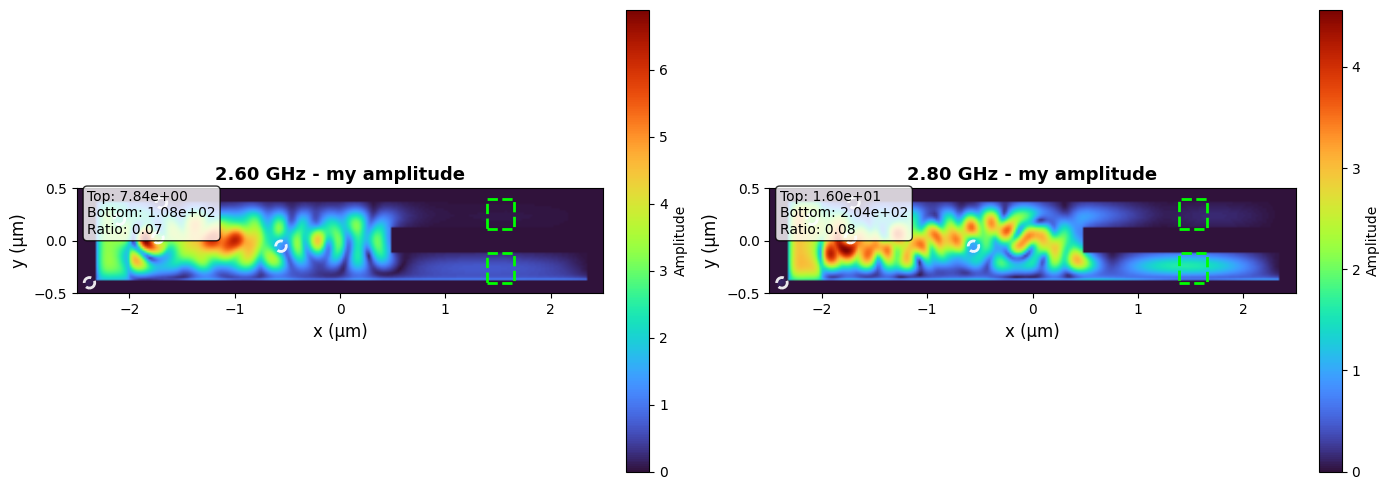


Visualization complete!


In [9]:
# VISUALISE BEST CONFIGURATION FFT RESULTS WITH DOTS OVERLAID
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (fmap, f) in enumerate(zip(maps, fpos)):
    ax = axes[i]
    
    # Sum over z-dimension for 2D visualization
    amp_map = np.sum(fmap, axis=0)
    
    # Plot with turbo colormap and physical coordinates
    extent = [x_phys[0]*1e6, x_phys[-1]*1e6, y_phys[0]*1e6, y_phys[-1]*1e6]
    im = ax.imshow(amp_map, origin='lower', cmap=turbo_cmap, 
                   extent=extent, aspect='auto', interpolation='bilinear')
    
    # Overlay dot contours from geometry
    X, Y = np.meshgrid(x_phys, y_phys)
    ax.contour(X*1e6, Y*1e6, dots_map, levels=[0.5], colors='white', 
               linewidths=1.5, linestyles='-', alpha=0.8)
    
    # Overlay dot positions as circles
    for dot_x, dot_y in best_dots:
        circle = plt.Circle((dot_x*1e6, dot_y*1e6), 0.05, 
                          color='white', fill=False, linewidth=2, 
                          linestyle='--', alpha=0.9)
        ax.add_patch(circle)
    
    # Draw measurement boxes
    freq_label = f"{f/1e9:.2f} GHz"
    bbox_top = results[freq_label]['bbox_top']
    bbox_bottom = results[freq_label]['bbox_bottom']
    
    # Top measurement box
    x_box_top = [x_phys[bbox_top[0]]*1e6, x_phys[bbox_top[1]]*1e6]
    y_box_top = [y_phys[bbox_top[2]]*1e6, y_phys[bbox_top[3]]*1e6]
    ax.plot([x_box_top[0], x_box_top[1], x_box_top[1], x_box_top[0], x_box_top[0]],
            [y_box_top[0], y_box_top[0], y_box_top[1], y_box_top[1], y_box_top[0]],
            'lime', linewidth=2, linestyle='--', label='Measurement region')
    
    # Bottom measurement box
    x_box_bottom = [x_phys[bbox_bottom[0]]*1e6, x_phys[bbox_bottom[1]]*1e6]
    y_box_bottom = [y_phys[bbox_bottom[2]]*1e6, y_phys[bbox_bottom[3]]*1e6]
    ax.plot([x_box_bottom[0], x_box_bottom[1], x_box_bottom[1], x_box_bottom[0], x_box_bottom[0]],
            [y_box_bottom[0], y_box_bottom[0], y_box_bottom[1], y_box_bottom[1], y_box_bottom[0]],
            'lime', linewidth=2, linestyle='--')
    
    # Formatting
    ax.set_xlabel('x (µm)', fontsize=12)
    ax.set_ylabel('y (µm)', fontsize=12)
    ax.set_title(f'{f/1e9:.2f} GHz - my amplitude', fontsize=13, fontweight='bold')
    ax.set_aspect('equal')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude', fontsize=10)
    
    # Add text annotations with measurements
    amp_top = results[freq_label]['top']
    amp_bottom = results[freq_label]['bottom']
    ax.text(0.02, 0.98, f'Top: {amp_top:.2e}\nBottom: {amp_bottom:.2e}\nRatio: {amp_top/amp_bottom:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('best_configuration_fft.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization complete!")


In [ ]:
savemat("output.mat",fields,appendmat=True)